In [1]:
#---------------------------------------------------------------------------------------------LIBRARIES--------------------------------------------------------------------------------------------                                                                                         #import OpenCV2 library for image processing and algorithms
import csv 
import numpy as np                                                                                     #import numpy mathematical library
import pandas as pd
import pickle
from micromlgen import port
import matplotlib.pyplot as plt      #import matplotlib library for plotting


from IPython.core.display import display, HTML                                    
display(HTML("<style>.container { width:100% !important; }</style>"))                                  #change width of Jupyer Notebook to use the whole window resolution availab

# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px

In [2]:
def save_statistics(clf, X_test, y_test, csv_filename, confusion_matrix_filename, metrics_filename):
    y_pred = []
    with open(csv_filename, "a", newline='') as fp:
        for row in X_test:
            result = int((str(clf.predict(row.reshape(1, -1))).replace('[','').replace(']','')))
            y_pred.append(result)
            wr = csv.writer(fp, dialect='excel')
            wr.writerow([result])
    fp.close()
    
    #https://www.baeldung.com/cs/multi-class-f1-score
    #https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case
    precision, recall, fscore, support = score(y_test.ravel(), y_pred)
    
    #https://towardsdatascience.com/understanding-the-confusion-matrix-from-scikit-learn-c51d88929c79
    #https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
    metrics = {"Accuracy: " : clf.score(X_test, y_test.ravel()),
               "F1 Score Weighted: " : f1_score(y_test, y_pred, average='weighted'), 
               "F1 Score per Class: " : fscore,
               "Precision per Class: " : precision,
               "Recall per Class: " : recall,
               "Support:  " : support}
    
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.savefig(confusion_matrix_filename, dpi=500)                                                                                     #https://stackoverflow.com/questions/9622163/save-plot-to-image-file-instead-of-displaying-it-using-matplotlib
    plt.show()
    
    print("CLASSES: Clear = 0, Rain = 1, Partially Cloudy = 2, Overcast = 3, Snow = 4" + "\n")
    with open(metrics_filename, 'w') as f:
        for k, v in metrics.items():
            f.write(str(k) + str(v) + '\n\n')
            print(str(k) + str(v))
    f.close()
    
def interractive_plot(X, y, a,b,c, interractive):
    classes = {'#ef8a62': '0', '#1cfc03': '1', '#67a9cf': '2', '#fc0303' : '3', '#00ffe5' : '4'}
    legend = {'#ef8a62': 'Fair', '#1cfc03': 'Rain', '#67a9cf': 'Cloudy', '#fc0303' : 'Overcast', '#00ffe5' : 'Snow'}
    colors = dict()
    for j, item in enumerate(y):
        for k, v in classes.items():
            if item == int(v): colors[j] = k
    
    if interractive is True:
        #https://plotly.com/python/3d-scatter-plots/
        fig = px.scatter_3d(X, a, b, c, color=colors, width=1300, height=1000,
                           labels={"x" : "Temperature", "y" : "Humidity", "z" : "Pressure"}, title="CLASSES CLUSTERS")  
        fig.for_each_trace(lambda t: t.update(name = legend[t.name]))
        fig.update_layout(legend_title_text='WEATHER')
        fig.show()
        
    else:
        #https://www.analyticsvidhya.com/blog/2021/10/interactive-plots-in-python-with-plotly-a-complete-guide/  <= great matplotlib article
        fig = plt.figure(figsize = (10, 10))
        ax = plt.axes(projection ="3d")
        kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
        ax.scatter3D(a, b, c, c=colors, **kwarg_params)
        ax.set_xlabel('Temperature', fontweight ='bold')
        ax.set_ylabel('Humidity', fontweight ='bold')
        ax.set_zlabel('Pressure', fontweight ='bold')
        plt.suptitle("Dataset Resampled with SMOTE")
        plt.show()
        
def oversampling(X_train, y_train, method):
    if method == 1: X_train, y_train = SMOTE().fit_sample(X_train, y_train)
    else: X_train, y_train = ADASYN().fit_sample(X_train, y_train)
    print(sorted(Counter(y_train).items()))
    print("Total training data: ", X_train.size)
    
    return X_train, y_train

Your Train Dataset is:  weather_data_2000_2019
Your Test Dataset is:  weather_data_2020_2021
Please choose 1 to display the dataset or any button to cotinue without displaying!1


array([[   7.9 ,    7.5 ,    6.9 ,   93.72, 1024.5 ],
       [   8.4 ,    7.7 ,    6.7 ,   89.02, 1025.3 ],
       [   9.1 ,    8.7 ,    7.8 ,   91.37, 1018.6 ],
       ...,
       [   7.4 ,    5.1 ,    5.2 ,   85.75, 1033.6 ],
       [   6.8 ,    5.3 ,    5.7 ,   93.15, 1029.7 ],
       [   7.3 ,    5.6 ,    6.5 ,   94.87, 1031.6 ]])

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

array([[   5.4 ,    4.  ,    3.9 ,   90.37, 1029.3 ],
       [   8.8 ,    7.2 ,    7.1 ,   89.27, 1020.4 ],
       [   8.3 ,    6.4 ,    5.2 ,   81.85, 1021.4 ],
       ...,
       [  11.2 ,   10.6 ,    9.1 ,   87.68, 1004.2 ],
       [  14.  ,   14.  ,   12.  ,   87.59, 1012.3 ],
       [  13.6 ,   13.6 ,   11.  ,   84.72, 1016.5 ]])

PLEASE CHOOSE 1 TO REBALANCE DATASET WITH SMOTE. CHOOSE 2 TO REBALANCE DATASET WITH ADASYN
PRESS ANYTHING ELSE TO CONTINUE WITH ORIGINAL!
2
[(0, 3424), (1, 3758), (2, 3816), (3, 3706), (4, 3755)]
Total training data:  92295


Please choose 1 for Training and 2 for Random CV Search.
Pressing 3 will load the optimised Gaussian Naive Bayes Classifier model!
3
Parameters Classifier Loaded:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 80, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 2000, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


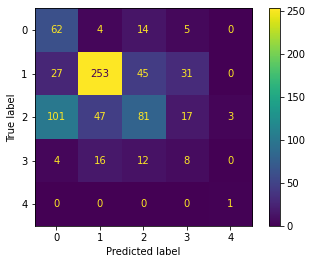

CLASSES: Clear = 0, Rain = 1, Partially Cloudy = 2, Overcast = 3, Snow = 4

Accuracy: 0.5540355677154583
F1 Score Weighted: 0.5630387146808283
F1 Score per Class: [0.44444444 0.74852071 0.40399002 0.15841584 0.4       ]
Precision per Class: [0.31958763 0.790625   0.53289474 0.13114754 0.25      ]
Recall per Class: [0.72941176 0.71067416 0.3253012  0.2        1.        ]
Support:  [ 85 356 249  40   1]


In [7]:
def main():
    #dataset selection and loading
    train_set_name = "weather_data_2000_2019"
    train_dataset = pd.read_csv(("./datasets/" + train_set_name + ".csv"),header=None)
    test_set_name = "weather_data_2020_2021"
    test_dataset = pd.read_csv(("./datasets/" + test_set_name + ".csv"),header=None) 

    print("Your Train Dataset is: ", train_set_name)                                                                       #display dataset name to user
    print("Your Test Dataset is: ", test_set_name)                                                                       #display dataset name to user

    features_selected = 5
    #training features
    temperature_train = train_dataset.iloc[:, 4:5]
    feels_like_train = train_dataset.iloc[:, 7:8]
    dew_point_train = train_dataset.iloc[:, 8:9]
    humidity_train = train_dataset.iloc[:, 9:10]
    pressure_train = train_dataset.iloc[:, 19:20] 
    #uv_index_train = train_dataset.iloc[:, 24:25] 

    #testing data
    temperature_test = test_dataset.iloc[:, 4:5]
    feels_like_test = test_dataset.iloc[:, 7:8]
    dew_point_test = test_dataset.iloc[:, 8:9]
    humidity_true = test_dataset.iloc[:, 9:10]
    pressure_test = test_dataset.iloc[:, 19:20]
    #uv_index_test = test_dataset.iloc[:, 24:25] 

    X_train = pd.concat([temperature_train, feels_like_train, dew_point_train, humidity_train, pressure_train], axis=1)   #, uv_index_train], axis=1)
    X_train.replace(([np.inf, -np.inf], np.nan), inplace=True)                                                            #replace any infinite values with nan
    X_train = X_train.to_numpy()  

    y_train = train_dataset.iloc[:, 30:31].to_numpy()
    y_true = test_dataset.iloc[:, 30:31].to_numpy()

    #https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
    test_data = pd.concat([temperature_test, feels_like_test, dew_point_test, humidity_true, pressure_test], axis=1)       #, uv_index_test], axis=1)       
    test_data.replace(([np.inf, -np.inf], np.nan), inplace=True)                                                           #replace any infinite values with nan
    X_test = test_data.to_numpy()

    #change all nan values in all datasets with the most frequent value of the dataset
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp.fit(X_train)
    imp.fit(y_train)
    imp.fit(X_test)
    imp.fit(y_true)
    
    disp = int(input("Please choose 1 to display the dataset or any button to cotinue without displaying!"))
    if disp == 1:
        display(X_train)
        display(y_train.ravel())

        display(X_test)
    else: print("Not displaying dataset!")   
        
    #----------------------------------------------------------------------------------------
    rebalance = int(input("PLEASE CHOOSE 1 TO REBALANCE DATASET WITH SMOTE. CHOOSE 2 TO REBALANCE DATASET WITH ADASYN" + 
                          "\nPRESS ANYTHING ELSE TO CONTINUE WITH ORIGINAL!\n"))
    if rebalance == 1:
        X_train, y_train = oversampling(X_train, y_train, 1)
    elif rebalance == 2:
        X_train, y_train = oversampling(X_train, y_train, 2)
    else: print("Total training data: ", X_train.size)
    
    interractive_plot(X_train, y_train, X_train[:, 0], X_train[:, 3], X_train[:, 4], True)
    #------------------------------------------------------------------------------------------
    
    #https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
    #https://www.analyticsvidhya.com/blog/2021/11/implementation-of-gaussian-naive-bayes-in-python-sklearn/
    choice = int(input("Please choose 1 for Training and 2 for Random CV Search." +
                       "\nPressing 3 will load the optimised Gaussian Naive Bayes Classifier model!\n"))
    if rebalance == 1: clf_type = "default_rebalanced_SMOTE" if choice == 1 else "optimised_rebalanced_SMOTE" 
    elif rebalance == 2: clf_type = "default_rebalanced_ADASYN" if choice == 1 else "optimised_rebalanced_ADASYN" 
    else: clf_type = "default" if choice == 1 else "optimised"
    model_name = "./trained_models/rfc_" + clf_type + "_" + train_set_name + "_" + test_set_name + "_" + str(features_selected) + "f.p"
    confusion_matrix_filename = "./confusion_matrix/rfc_" + str(clf_type) + "_" + train_set_name + "_"  + test_set_name + "_" + str(features_selected) + "f.png"
    metrics_filename = "./metrics/rfc_" + str(clf_type) + "_" + train_set_name + "_"  + test_set_name + "_" + str(features_selected) + "f.txt"
    csv_filename = "./outputs/output_rfc_"  + str(clf_type) + "_" + train_set_name + "_"  + test_set_name + "_" + str(features_selected) + "f.csv"

    if choice == 1:
        # Create Random Forest classifer object and train it on the selected dataset
        rfc = (RandomForestClassifier()).fit(X_train, y_train.ravel())
        save_statistics(rfc, X_test, y_true, csv_filename, confusion_matrix_filename, metrics_filename)

    elif choice == 2:
        rfc = RandomForestClassifier()
        
        #random search hyperparameters optimisation
        param_random = {'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4],
                        'max_features': ['auto', 'sqrt', 'log2'],
                        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
                        'bootstrap': [True, False]}

        rfc_random_search = RandomizedSearchCV(estimator = rfc, param_distributions = param_random, 
                                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = 14)
        rfc_random_search.fit(X_train, y_train.ravel())
        best_random_search = list(rfc_random_search.best_params_.values())
        print(rfc_random_search.best_params_)

        #grid search hyperparameters optimisation based on low range random search best result
        param_grid = {'n_estimators': [int(best_random_search[0]-100), int(best_random_search[0]-50), int(best_random_search[0]-25), int(best_random_search[0]),
                                                                  int(best_random_search[0]+25), int(best_random_search[0])+50, int(best_random_search[0])+100],
                      'min_samples_split': [int(best_random_search[1]/3), int(best_random_search[1]/2), int(best_random_search[1]), 
                                                                       int(best_random_search[1]*2), int(best_random_search[1]*3)],
                      'min_samples_leaf': [best_random_search[2]-1, best_random_search[1], best_random_search[1]+1],
                      'max_features': ['auto', 'sqrt', 'log2'],
                      'max_depth': [best_random_search[4]-10, best_random_search[4]-5, best_random_search[4], 
                                                          best_random_search[4]+5, best_random_search[4]+10],
                      'bootstrap': [best_random_search[5]]}

        rfc_grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                                       cv = 5, n_jobs = 14, verbose = 2)
        rfc_grid_search.fit(X_train, y_train.ravel())
        best_grid_search = list(rfc_grid_search.best_params_.values()) 
        print(rfc_grid_search.best_params_)                                                                                           # print best parameter after tuning
        print(rfc_grid_search.best_estimator_)                                                                                        # print how our model looks after hyper-parameter tuning
        
        pickle.dump(rfc_grid_search.best_estimator_, open(model_name, "wb"))

    elif choice == 3:
        rfc = pickle.load(open(model_name, "rb"))
        print("Parameters Classifier Loaded: ", rfc.get_params())

        save_statistics(rfc, X_test, y_true, csv_filename, confusion_matrix_filename, metrics_filename)

if __name__ == "__main__":                                                                                               #guard boilerplate
    main()